# Cross validation analysis of final evaluation results between different techniques

Tong Shu Li<br>
Created on: 2015-10-08<br>
Last updated: 2015-10-26

The team at UTexas was kind enough to send their final predictions for the CID task. We will compare their results to the crowd's and see where their outputs differed.

In [1]:
from collections import defaultdict
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as robjects
import sys

In [2]:
RAND_KEY = np.random.RandomState(20151007)
matplotlib.rcParams.update({'font.size': 12})
TRIPLE = ["pmid", "chemical_id", "disease_id"]
pd.options.mode.chained_assignment = None
pd.set_option("max_colwidth", 100)

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
sys.path.append("..")

In [5]:
from src.lingpipe.file_util import read_file
from src.lingpipe.file_util import save_file

from src.data_model import Ontology_ID
from src.data_model import Relation
from src.data_model import parse_input
from src.data_model import parse_file
from src.data_model import Annotation

from src.eval_perf import performance
from src.eval_perf import official_F_score
from src.parse_mesh import load_mesh
from src.get_mesh_terms import Article

---

## Global functions

In [6]:
def make_df(triples):
    """Converts a given set of (pmid, chemical_id, disease_id)
    triples into a three column dataframe."""
    return pd.DataFrame(list(triples), columns = TRIPLE)

In [7]:
def get_triples(dataframe):
    return set(dataframe[TRIPLE].apply(
                lambda row: (int(row["pmid"]), row["chemical_id"], row["disease_id"]), axis = 1))

In [8]:
def format_set(v):
    return "\n".join(map(str, v))

def print_to_file(fname, dataset):
    with open(fname, "w") as fout:
        fout.write(dataset)

### Read the gold standard and various solutions

In [9]:
def read_output(fname):
    """Read only the CID relations from a Pubtator-formatted
    text file.
    """
    temp = defaultdict(list)
    for line in read_file(fname):
        vals = line.split("\t")
        
        if len(vals) > 1 and vals[1] == "CID":
            temp["pmid"].append(int(vals[0]))
            temp["chemical_id"].append(Ontology_ID(vals[2]).flat_repr)
            temp["disease_id"].append(Ontology_ID(vals[3]).flat_repr)
            
            if len(vals) > 4:
                temp["threshold"].append(float(vals[4]))

    return pd.DataFrame(temp)

In [10]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development", "test"]
    assert file_format in ["list", "dict"]
    
    fname = "parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    save_loc = os.path.abspath(os.path.join("..", "data", "gold_standard", fname))
    
    fname = "CDR_{0}Set.txt".format(dataset.capitalize())
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard"))
    
    return parse_file(save_loc, loc = loc, fname = fname,
        is_gold = True, return_format = file_format, fix_acronyms = False)

In [11]:
def has_concept(paper, concept_id):
    concepts = set()
    for annot in paper.annotations:
        concepts |= set([iden.flat_repr for iden in annot.uid if iden.uid_type == "MESH"])
    
    return concept_id in concepts

In [12]:
def check_exists(df, reference):
    for col in ["chemical", "disease"]:
        df.loc[:, "{}_exists".format(col[:4])] = df[TRIPLE].apply(
            lambda row: has_concept(reference[int(row["pmid"])], row["{}_id".format(col)]), axis = 1)
        
    return df

### Read the PMID mappings

In [13]:
paper_mapping = save_file("testset_mapping.pickle")

### Read the gold standard

In [14]:
eval_gold = read_gold_standard("test", file_format = "dict")

In [15]:
fname = os.path.abspath(os.path.join("..", "data", "gold_standard", "CDR_TestSet.txt"))
gold_std = read_output(fname)

### Grab the official MeSH terms for the testset and save to pickle

In [16]:
def grab_mesh(papers):
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard", "testset_mesh_terms.pickle"))

    res = save_file(loc)
    if res is not None:
        return res
    
    res = dict()
    for pmid in papers:
        res[pmid] = Article(pmid)
        
    save_file(loc, res)
    return res

In [17]:
mesh_terms = grab_mesh(set(eval_gold.keys()))

### Read UTexas's results

In [18]:
fname = os.path.abspath(os.path.join("..", "data", "utexas", "CDR_TestSet.BiC.V.CID.Run3.txt"))
ut_res = read_output(fname)

ut_res = check_exists(ut_res, eval_gold)

# fully parsed results
save_loc = os.path.abspath(os.path.join("..", "data", "utexas", "texas_full_testset.pickle"))
loc = os.path.abspath(os.path.join("..", "data", "utexas"))
ut_full = parse_file(save_loc, loc = loc, fname = "CDR_TestSet.BiC.V.CID.Run3.txt",
    is_gold = True, return_format = "dict", fix_acronyms = False)

### Read the crowd's results

In [19]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_testset.pickle"))
crowd_full = save_file(loc)
crowd_res = save_file("testset_final_res.pickle")

In [20]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "abstract_relation_res.tsv"))

abs_res = pd.read_csv(loc, sep = '\t', dtype = {"unit_id": str})
abs_res = abs_res.rename(columns = {"percent_agree": "norm_conf_score",
                                   "unit_id": "unit_ids"})

abs_res.loc[:, "pmid"] = abs_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])
abs_res.loc[:, "unit_ids"] = abs_res.loc[:, "unit_ids"].astype(int)

In [21]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "sentence_relation_abs_res.tsv"))
sent_res = pd.read_csv(loc, sep = '\t', dtype = {"unit_ids": str})

sent_res = sent_res.rename(columns = {"conf_score": "norm_conf_score",
                                      "score_vote_max": "num_votes"})

sent_res.loc[:, "pmid"] = sent_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])

### Read BeFree's results

In [22]:
fname = os.path.abspath(os.path.join("..", "data", "befree", "final_eval", "befree_testset_results.txt"))
befree_res = read_output(fname)

befree_res.loc[:, "pmid"] = befree_res["pmid"].map(lambda val: paper_mapping[val])
befree_res["threshold"] = 1

befree_res = check_exists(befree_res, eval_gold)

#----------------------------------

def get_befree():
    loc = os.path.join("..", "data", "befree", "final_eval")

    save_loc = os.path.abspath(os.path.join(loc, "befree_testset_full.pickle"))
    res = save_file(save_loc)
    if res is not None:
        return res

    befree_full = parse_input(os.path.abspath(loc), "befree_testset_results.txt",
                         is_gold = True, return_format = "dict", fix_acronyms = False)

    temp = dict()
    for pmid, paper in befree_full.items():
        paper.pmid = paper_mapping[pmid]
        temp[paper_mapping[pmid]] = paper

    save_file(save_loc, temp)
    return temp
    
befree_full = get_befree()

In [23]:
gold_std.head()

,chemical_id,disease_id,pmid
0,MESH:D015738,MESH:D003693,8701013
1,MESH:D007213,MESH:D007022,439781
2,MESH:D016572,MESH:D057049,22836123
3,MESH:D000305,MESH:D012595,22836123
4,MESH:D016559,MESH:D012595,22836123


In [24]:
ut_res.head()

,chemical_id,disease_id,pmid,threshold,chem_exists,dise_exists
0,MESH:D015738,MESH:D003693,8701013,0.75,True,True
1,MESH:D015738,MESH:D014456,8701013,0.65,True,True
2,MESH:D007213,MESH:D007022,439781,0.75,True,True
3,MESH:D016572,MESH:D057049,22836123,0.75,True,True
4,MESH:D016559,MESH:D057049,22836123,0.65,True,True


In [25]:
crowd_res.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
0,MESH:C009695,MESH:D000699,0.000000,0,35781,sentence_task
1,MESH:C009695,MESH:D002375,0.000000,0,35781,sentence_task
2,MESH:D003000,MESH:D000699,0.000000,0,35781,sentence_task
3,MESH:D009278,MESH:D002375,0.000000,0,35781,sentence_task
4,MESH:D009638,MESH:D000699,0.185347,1,35781,abstract_task


In [26]:
befree_res.head()

,chemical_id,disease_id,pmid,threshold,chem_exists,dise_exists
0,MESH:D015738,MESH:D003693,8701013,1,True,True
1,MESH:D007213,MESH:D007022,439781,1,True,True
2,MESH:D016559,MESH:D045743,22836123,1,True,False
3,MESH:D008694,MESH:D011618,23433219,1,True,False
4,MESH:D007980,MESH:D004409,23535177,1,True,True


---

## Overall performance against the gold standard

Using the official evaluation of the CID relation performance, how did each solution do?

### Get the gold standard triples

In [78]:
gold_triples = get_triples(gold_std)

### University of Texas performance

In [79]:
official_F_score("threshold", gold_triples, ut_res)

,F_score,precision,recall,threshold
0,0.570252,0.556747,0.584428,0.30
1,0.585269,0.618600,0.555347,0.65
2,0.520915,0.642366,0.438086,0.75


These results match exactly the published results. Note that the system would have done even better if it set its threshold to the middle value of 0.65 instead of the lowest value of 0.30.

### Crowd performance

In [80]:
official_F_score("num_votes", gold_triples, crowd_res)

,F_score,precision,recall,threshold
0,0.267624,0.162805,0.751407,0
1,0.356317,0.236486,0.722326,1
2,0.444779,0.327426,0.693246,2
3,0.496480,0.410288,0.628518,3
4,0.505929,0.475640,0.540338,4
5,0.465066,0.556136,0.399625,5
6,0.003742,0.666667,0.001876,6


In [81]:
# removing anything with serotonin or dopamine increases precision without reducing recall
# therefore it is always wrong to say serotonin or dopamine causes a disease in this dataset
official_F_score("num_votes", gold_triples,
    crowd_res.query("chemical_id not in {}".format(["MESH:D004298", "MESH:D012701"])))

,F_score,precision,recall,threshold
0,0.271020,0.165325,0.751407,0
1,0.360656,0.240325,0.722326,1
2,0.449240,0.332284,0.693246,2
3,0.499627,0.414604,0.628518,3
4,0.507713,0.478803,0.540338,4
5,0.465319,0.556863,0.399625,5
6,0.003742,0.666667,0.001876,6


### BeFree performance

In [30]:
official_F_score("threshold", gold_triples, befree_res)

,F_score,precision,recall,threshold
0,0.428571,0.486874,0.382739,1


My calculations show that BeFree's official published performance (F 0.4281) is slightly worse than what I have calculated, despite my method accurately reproducing both UTexas's and our results. Perhaps Alex sent me a slightly modified version of the data they submitted?

In [31]:
ut_trip = get_triples(ut_res)
crowd_trip = get_triples(crowd_res.query("num_votes >= 4"))
befree_trip = get_triples(befree_res)

---

## Performance on a subset of relations where the annotations were perfectly identified

Since we have seen that NER has a huge influence on the performance, we will look backwards to see what performance was like on relations where both the chemical and disease were perfectly identified (i.e. the annotations all match the gold standard).

In [32]:
def extract_ids(annotations):
    concepts = defaultdict(set)
    for annot in annotations:
        concepts[annot.stype].add(annot.uid)

    return concepts

def expand_set(vals):
    res = set()
    for v in vals:
        res |= v
        
    return res

def find_perfect_subset(reference, gold_std):
    """Given a gold standard, the predictions, and the triple sets,
    removes relations which used concepts that had annotation mismatches
    between the predictions and the gold.
    """
    good_trips = set()
    for pmid, gold_paper in gold_std.items():
        paper = reference[pmid]

        # annotations
        predict_annot = set(paper.annotations)
        gold_annot = set(gold_paper.annotations)
        
        shared_concepts = extract_ids(gold_annot & predict_annot)
        missed_concepts = extract_ids(gold_annot ^ predict_annot)
        
        perf_chem = shared_concepts["chemical"] - missed_concepts["chemical"]
        perf_dise = shared_concepts["disease"] - missed_concepts["disease"]
        
        chems = expand_set(perf_chem)
        dises = expand_set(perf_dise)
            
        good_trips |= set([(pmid, chem.flat_repr, dise.flat_repr) for chem in chems for dise in dises])

    return good_trips

def perfect_perf(predict_full, orig_df, threshold, gold_std, gold_trip):
    poss_good_trips = find_perfect_subset(predict_full, gold_std)
    
    # all pmids where there was at least one (chemical, disease) pair
    # where both concepts were annotated perfectly between the gold
    # and the method's NER outputs
    good_pmids = {val[0] for val in poss_good_trips}
    
    predict_trip = get_triples(orig_df)    
    
    # filter gold standard relations and predicted relations by
    # whether both concepts were perfectly annotated in both gold
    # and the predictions
    good_pred_trip = poss_good_trips & predict_trip
    good_gold_trip = poss_good_trips & gold_trip
    
    assert good_pmids >= {v[0] for v in good_pred_trip} | {v[0] for v in good_gold_trip}
    
    print("# of gold triples {}".format(len(good_gold_trip)))
    
    # subset the original predictions down to those with perfect
    # annotations
    good_pred_df = make_df(good_pred_trip)
    pred_sub = pd.merge(good_pred_df, orig_df, how = "left", on = ["pmid", "chemical_id", "disease_id"])
    
    return (pred_sub, official_F_score(threshold, good_gold_trip, pred_sub),
            make_df(good_gold_trip))

In [33]:
crowd_no_ner, crowd_no_ner_perf, crowd_good_gold = perfect_perf(crowd_full,
                                crowd_res, "num_votes", eval_gold, gold_triples)

# of gold triples 485


In [34]:
crowd_no_ner_perf

,F_score,precision,recall,threshold
0,0.318346,0.189305,1.000000,0
1,0.434339,0.280240,0.964948,1
2,0.540541,0.381356,0.927835,2
3,0.615958,0.482477,0.851546,3
4,0.645447,0.565015,0.752577,4
5,0.603732,0.645540,0.567010,5
6,0.008214,1.000000,0.004124,6


These results are slightly better than the simple NER filtering that I was using before, where I only check whether the concept was identified at all in the paper. However, the performance is basically the same, still in the low 0.6 F range.

In [35]:
texas_no_ner, texas_no_ner_perf, ut_good_gold = perfect_perf(ut_full, ut_res, "threshold", eval_gold, gold_triples)

# of gold triples 579


In [36]:
texas_no_ner_perf

,F_score,precision,recall,threshold
0,0.668800,0.622951,0.721934,0.30
1,0.668354,0.653465,0.683938,0.65
2,0.600966,0.682018,0.537133,0.75


The UTexas solution still performs better than our crowd, although more gold relations comes from a smaller number of abstracts.

In [37]:
befree_no_ner, befree_no_ner_perf, befree_good_gold = perfect_perf(befree_full, befree_res, "threshold", eval_gold, gold_triples)

# of gold triples 460


In [38]:
befree_no_ner_perf

,F_score,precision,recall,threshold
0,0.588774,0.622276,0.558696,1


---

## Error analysis

Null hypothesis: the origin of a relation is independent of the category that the relation belongs to (true positive, false positive, false negative).

We use the Chi square test to determine whether the null hypothesis is true. We will group CID and sentence bound relations together.

In [39]:
def converter(pmid, poss_relations):
    return [Relation(pmid, rel[0], rel[1]) for rel in poss_relations]

def rel_origin(triple, paper):
    relation = Relation(paper.pmid, triple[1], triple[2], flat = False)

    rename = {
        "CID": "sent",
        "sentence_non_CID": "sent",
        "not_sentence_bound": "abs"
    }
    
    ans = []
    for key, val in paper.poss_relations.items():
        value = converter(paper.pmid, val)
        if relation in value:
            ans.append(rename[key])

    return "|".join(ans)

In [40]:
def single_triple(row):
    return (int(row["pmid"]), row["chemical_id"], row["disease_id"])

def make_summary(predictions, gold_std):
    temp = pd.merge(predictions[TRIPLE], gold_std[TRIPLE], how = "outer", on = TRIPLE)
    
    pred_trip = get_triples(predictions)
    gold_trip = get_triples(gold_std)
    
    temp.loc[:, "in_gold"] = temp.loc[:, TRIPLE].apply(
        lambda row: single_triple(row) in gold_trip, axis = 1
    )
    
    temp.loc[:, "in_predict"] = temp.loc[:, TRIPLE].apply(
        lambda row: single_triple(row) in pred_trip, axis = 1
    )
    
    temp.loc[:, "rel_origin"] = temp.loc[:, TRIPLE].apply(
        lambda row: rel_origin(single_triple(row), eval_gold[row["pmid"]]), axis = 1
    )
    
    temp.loc[:, "pmid"] = temp.loc[:, "pmid"].astype(int)
    
    return temp

In [41]:
def category_splitter(predict_res, gold_std, option = ""):
    """A generator for categories of relations."""
    predict = make_summary(predict_res, gold_std)
    
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    for etype, val in zip(error_type, vals):
        sub = predict.query("in_gold == {} and in_predict == {}{}".format(
            val[0], val[1], option
        )).dropna()
        
        yield (etype, sub)

In [42]:
def two_samp_ttest(res):
    ttest = robjects.r["t.test"]
    for a, b in combinations(["TP", "FP", "FN"], 2):
        print("T test between {} and {}".format(a, b))
        result = ttest(res[a], res[b])
        # don't print the acutal series themselves
        # result[8] contains the data.name vectors
        # overwriting with zero suppresses superfluous output
        result[8] = 0
        print(result)
        print("-----------------------------")

In [43]:
def test_origin(pred_res, gold_std):
    """Apply the Chi-square test to see if a relation's
    origin is independent of the category of error it
    belongs to.
    """
    chisqtest = robjects.r["chisq.test"]
    
    res = dict()
    for etype, sub in category_splitter(pred_res, gold_std):
        res[etype] = sub["rel_origin"].value_counts()[["sent", "abs"]]
        
    res = pd.DataFrame(res).T
    
    print(chisqtest(res))
    
    return res

In [44]:
test_origin(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold)


	Pearson's Chi-squared test

data:  structure(list(sent = structure(c(55L, 181L, 290L), .Dim = 3L),     abs = structure(c(65L, 100L, 74L), .Dim = 3L)), .Names = c("sent", "abs"), row.names = c("FN", "FP", "TP"), class = "data.frame")
X-squared = 52.006, df = 2, p-value = 5.095e-12




,sent,abs
FN,55,65
FP,181,100
TP,290,74


In [45]:
test_origin(texas_no_ner, ut_good_gold)


	Pearson's Chi-squared test

data:  structure(list(sent = structure(c(56L, 192L, 339L), .Dim = 3L),     abs = structure(c(104L, 60L, 77L), .Dim = 3L)), .Names = c("sent", "abs"), row.names = c("FN", "FP", "TP"), class = "data.frame")
X-squared = 125.96, df = 2, p-value < 2.2e-16




,sent,abs
FN,56,104
FP,192,60
TP,339,77


In [46]:
test_origin(befree_no_ner, befree_good_gold)


	Pearson's Chi-squared test

data:  structure(list(sent = structure(c(109L, 77L, 212L), .Dim = 3L),     abs = structure(c(93L, 79L, 45L), .Dim = 3L)), .Names = c("sent", "abs"), row.names = c("FN", "FP", "TP"), class = "data.frame")
X-squared = 61.902, df = 2, p-value = 3.615e-14




,sent,abs
FN,109,93
FP,77,79
TP,212,45


So based on the high values of the test statistic, it seems that the relation origin is not independent of the category of the relation for all three different solutions. This means that the three different subgroups have different proportions of abstract and sentence bound relations.

---

### Manual error analysis sampling

In [47]:
crowd_summary = make_summary(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold)

In [48]:
cols = crowd_summary.columns | ["unit_ids"]

crowd_summary = pd.merge(crowd_summary,
    pd.concat([sent_res, abs_res]), how = "left", on = TRIPLE)[cols]

The null unit ids section is for CID relations which have no corresponding work units.

In [49]:
crowd_summary.head()

,chemical_id,disease_id,in_gold,in_predict,pmid,rel_origin,unit_ids
0,MESH:D007069,MESH:D012640,True,True,24209900,abs,773936072
1,MESH:D010672,MESH:D008206,True,True,146391,sent,773932414|773932417|773932419|773932423
2,MESH:C071741,MESH:D007022,True,True,19178808,sent,773934359|773934362|773934363|773934365
3,MESH:D005045,MESH:D010146,True,True,612112,abs,773936632
4,MESH:D018170,MESH:D003329,False,True,9759693,sent,773933474


---

### T-test of length for abstract scope errors

For the relations which are abstract scoped, does crowd performance depend upon how long the abstracts are? I.e., do workers perform worse on longer abstracts because there's more reading?

In [50]:
def ttest_length(pred_res, gold_std, gold_full, test):
    """Apply the Student's t-test to see if the category an
    abstract relation falls into is determined by the length
    of the abstract or the number of sentences.
    """
    assert test in ["length", "sentences"]
    
    res = dict()    
    for e_type, sub in category_splitter(pred_res, gold_std, " and rel_origin == 'abs'"):
        papers = list(sub["pmid"])
        if test == "length":
            res[e_type] = pd.Series([
                len(gold_full[pmid].title) + len(gold_full[pmid].abstract) + 1
                for pmid in papers
            ])
        elif test == "sentences":
            res[e_type] = pd.Series([
                len(gold_full[pmid].sentences) for pmid in papers
            ])
        
    two_samp_ttest(res)

In [51]:
ttest_length(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "length")

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = 1.4014, df = 159.92, p-value = 0.163
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -41.2189 242.6632
sample estimates:
mean of x mean of y 
 1364.662  1263.940 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = -1.9551, df = 129.78, p-value = 0.05272
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -328.40695    1.94666
sample estimates:
mean of x mean of y 
 1364.662  1527.892 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = -3.3129, df = 129.25, p-value = 0.001198
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -421.5881 -106.3165
sample estimates:
mean of x mean of y 
 1263.940  1527.892 


-----------------------------


In [52]:
ttest_length(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "sentences")

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = 0.75537, df = 165.67, p-value = 0.4511
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6210935  1.3908233
sample estimates:
mean of x mean of y 
 9.864865  9.480000 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = -1.8031, df = 122.4, p-value = 0.07384
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.3168117  0.1080799
sample estimates:
mean of x mean of y 
 9.864865 10.969231 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = -2.4676, df = 125.71, p-value = 0.01495
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.6835931 -0.2948684
sample estimates:
mean of x mean of y 
  9.48000  10.96923 


-----------------------------


In [53]:
ttest_length(texas_no_ner, ut_good_gold, eval_gold, "length")

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = 0.28482, df = 121.12, p-value = 0.7763
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -141.8738  189.5561
sample estimates:
mean of x mean of y 
 1459.208  1435.367 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = 0.1409, df = 179, p-value = 0.8881
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -147.8836  170.6261
sample estimates:
mean of x mean of y 
 1459.208  1447.837 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = -0.13956, df = 144.64, p-value = 0.8892
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -189.0764  164.1367
sample estimates:
mean of x mean of y 
 1435.367  1447.837 


-----------------------------


In [54]:
ttest_length(befree_no_ner, befree_good_gold, eval_gold, "length")

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = -1.3116, df = 80.476, p-value = 0.1934
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -275.64730   56.63352
sample estimates:
mean of x mean of y 
 1447.822  1557.329 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = -0.23017, df = 104.82, p-value = 0.8184
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -204.0291  161.5875
sample estimates:
mean of x mean of y 
 1447.822  1469.043 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = 1.1763, df = 164.1, p-value = 0.2412
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -59.91545 236.48766
sample estimates:
mean of x mean of y 
 1557.329  1469.043 


-----------------------------


#### Crowd:

**Hypothesis**: Workers are more likely to have difficulty with long abstracts due to the amount of reading and long-distance word dependencies.

Based on the t-test results, it seems that there is no difference in length between the true positives and false positives or false negatives. However, there does seem to be a difference in length between the false positives and the false negatives. The false positives were significantly more likely to arise from abstracts which were shorter in length, while the false negatives were more likely to be in longer abstracts.

We see no such evidence of such a dependency in both of the machine learning approaches. Length of the abstract has no bearing on what kind of category the relation will fall into.

Number of sentences has no effect either.

I think that the last result supports the hypothesis that workers are more likely to miss relations in longer abstracts due to more reading and long scale word dependency.

---

### Parallelism test

**Hypothesis**: false positives are likely to show up in sentences containing other true positives.

Example: in PMID 3289726, the gold has three relations, between etoposide (D005047) and three diseases: confusion (D003221), seizure (D012640), and papilledema (D010211). The abstract states: "Significant clinical manifestations have included confusion, papilledema, somnolence, exacerbation of motor deficits, and sharp increase in seizure activity."

Therefore all of the mentioned diseases are related to etoposide. There should in reality be 5 relations in the gold, but one is not possible (motor deficits) because there is no corresponding MeSH term, and the other seems to be a missing relation (a mistake) in the gold standard. However, the missing relation was stated as true with high confidence by our crowd, so we can use this as a filter to find false positives by the crowd which are likely to be true.

In [55]:
def get_concepts(stype, sentence):
    res = set()
    for annot in sentence.annotations:
        if annot.stype == stype:
            res |= annot.uid
        
    return res

def count_parallel(pmid, chem, dise):
    """For a given relation, look at the sentence that the
    disease is in and look for true relations using the
    chemical and another disease in the same sentence.
    
    Usually there is parallelism and the list of diseases
    in the sentence will all be true (as a list of symptoms
    for that chemical etc.)
    
    Example: PMID 3289726, where one sentence contains all the
    true relations.
    """
    paper = eval_gold[pmid]
    
    # find the sentences containing the disease id
    chem_id = Ontology_ID(chem)
    dise_id = Ontology_ID(dise)   
    
    res = 0
    for sentence in paper.sentences:
        concepts = get_concepts("disease", sentence)

        if dise_id in concepts:
            other = concepts - set([dise_id])
            
            poss = [Relation(pmid, frozenset([chem_id]),
                frozenset([concept])) for concept in other]
            
            ans = [int(paper.has_relation(val)) for val in poss]
            res += sum(ans)
            
    return res       

In [56]:
def ttest_parallel(pred_res, gold_std, gold_full):
    """Determine whether the category of a relation is independent
    of the number of other parallel relations in the same sentence.
    """
    res = dict()
    for e_type, sub in category_splitter(pred_res, gold_std, " and rel_origin == 'abs'"):
        res[e_type] = pd.Series(sub[TRIPLE].apply(
            lambda r: count_parallel(r["pmid"], r["chemical_id"], r["disease_id"]),
            axis = 1
        ))
        
    two_samp_ttest(res)        
    return res

In [57]:
res = ttest_parallel(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold)

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = 5.3173, df = 138.49, p-value = 4.119e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7783989 1.6999795
sample estimates:
mean of x mean of y 
 1.689189  0.450000 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = -0.34741, df = 121.76, p-value = 0.7289
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7422382  0.5206165
sample estimates:
mean of x mean of y 
 1.689189  1.800000 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = -4.6709, df = 99.281, p-value = 9.427e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.9234712 -0.7765288
sample estimates:
mean of x mean of y 
     0.45      1.80 


-----------------------------


In [58]:
res["TP"].value_counts()

2    21
0    20
1    18
3     6
6     4
5     3
4     2
dtype: int64

In [59]:
res["FP"].value_counts()

0    83
1     8
3     4
7     3
2     2
dtype: int64

In [60]:
res["FN"].value_counts()

0    29
4    10
1     8
2     7
5     5
6     4
3     2
dtype: int64

In [61]:
fps = crowd_summary.query("~in_gold and in_predict and rel_origin == 'abs'")

fps.loc[:, "link"] = fps.loc[:, "unit_ids"].map(lambda v: "https://crowdflower.com/jobs/767273/units/{}".format(v))

fps.loc[:, "parallel"] = fps.loc[:, TRIPLE].apply(
    lambda r: count_parallel(r["pmid"], r["chemical_id"], r["disease_id"]),
    axis = 1
)

In [62]:
fps.query("parallel > 2").sort("parallel", ascending = False)

,chemical_id,disease_id,in_gold,in_predict,pmid,rel_origin,unit_ids,link,parallel
98,MESH:D004317,MESH:D060831,False,True,11745287,abs,773937713,https://crowdflower.com/jobs/767273/units/773937713,7
106,MESH:D016190,MESH:D060831,False,True,11745287,abs,773937706,https://crowdflower.com/jobs/767273/units/773937706,7
456,MESH:D004317,MESH:D013280,False,True,11745287,abs,773937712,https://crowdflower.com/jobs/767273/units/773937712,7
202,MESH:D005047,MESH:D006970,False,True,3289726,abs,773936980,https://crowdflower.com/jobs/767273/units/773936980,3
317,MESH:D003613,MESH:D063806,False,True,2358093,abs,773936830,https://crowdflower.com/jobs/767273/units/773936830,3
546,MESH:D014635,MESH:D001523,False,True,24614773,abs,773936176,https://crowdflower.com/jobs/767273/units/773936176,3
560,MESH:D002231,MESH:D005076,False,True,19263707,abs,773938382,https://crowdflower.com/jobs/767273/units/773938382,3


Based on the data, we see that the true positive abstract-scope relations usually use diseases which occur in sentences with other diseases which also are related to the current chemical (mean 1.7 other instances). However, with the false positives, this is no longer true (mean 0.45). Based on these data, we propose using the number of parallel relations as a filter for determining errors in the gold standard. As in, relations which were left out in the gold standard, but should really be true because they are in sentences where the other relations were all related to the same chemical. We posit that these relations were missed due to human error. The list is given in the cell above.

---

### Sentence-bound relations

**Hypothesis**: for sentence-bound relations, the crowd performs better when the amount of context increases, that is, the number of tasks (sentences) that the two concepts cooccur in increases. If there is too little context, i.e. only one task (sentence) for a single relation, then we would expect the workers to do poorly because the sentence is taken out of context. In contrast, if there were multiple tasks, then we expect that it is more likely that one of the sentences will have captured the true relationship between the concepts, and therefore giving a higher probability that the crowd will identify the true relation.

Therefore we expect that the category of a relation (TP, FP, FN) will not be independent of the number of sentences.

In [63]:
def ttest_freq(summary):
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    res = dict()
    for etype, val in zip(error_type, vals):
        sub = summary.query("in_gold == {} and in_predict == {} and rel_origin == 'sent'".format(
            val[0], val[1])
        ).dropna() # CID relations are filtered out!
        
        res[etype] = pd.Series(sub["unit_ids"].map(lambda v: len(v.split("|"))))

    two_samp_ttest(res)
    return res

In [64]:
res = ttest_freq(crowd_summary)

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = 3.3959, df = 340.99, p-value = 0.0007648
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1562751 0.5864964
sample estimates:
mean of x mean of y 
 1.845745  1.474359 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = 3.8217, df = 121.59, p-value = 0.0002104
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2411333 0.7594470
sample estimates:
mean of x mean of y 
 1.845745  1.345455 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = 0.99852, df = 114.69, p-value = 0.3201
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1268162  0.3846251
sample estimates:
mean of x mean of y 
 1.474359  1.345455 


-----------------------------


Based on the two sample t-test, it seems that there are significant differences in the number of sentence tasks between the true positives and both false positives and false negatives. There are no differences between the false positive and false negatives. From this I conclude that the null hypothesis is false, and that sentence-scoped relations with greater numbers of tasks are more likely to be classified by the crowd as true positives instead of as either type of error.

Therefore it does seem that a lack of context is affecting crowd performance. When there are more sentences containing the relation pair, it is more likely to be classified properly.

---

### Title sentences

**Hypothesis**: titles are confusing sentences which are more likely to state a tested hypothesis rather than the results of testing that hypothesis. Therefore we hypothesize that the errors are more likely to contain titles than the true positives.

In [65]:
def ttest_title(summary):
    temp = pd.merge(summary, sent_res[TRIPLE + ["sentence_ids"]], how = "left", on = TRIPLE)
    
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    chisqtest = robjects.r["chisq.test"]
    
    res = dict()
    for etype, val in zip(error_type, vals):
        sub = temp.query("in_gold == {} and in_predict == {} and rel_origin == 'sent'".format(
            val[0], val[1])
        ).dropna()

        sub.loc[:, "title"] = sub.loc[:, "sentence_ids"].map(
            lambda v:
                sum(int(val == "0") for val in map(lambda f: f.split("_")[1], v.split("|")))
        )
        
        res[etype] = sub["title"].value_counts()[[0, 1]]

    res = pd.DataFrame(res)
    
    print(chisqtest(res))
    return res

In [66]:
ttest_title(crowd_summary)


	Pearson's Chi-squared test

data:  structure(list(FN = structure(c(47L, 8L), .Dim = 2L), FP = structure(c(123L, 33L), .Dim = 2L), TP = structure(c(114L, 74L), .Dim = 2L)), .Names = c("FN", "FP", "TP"), row.names = c("0", "1"), class = "data.frame")
X-squared = 20.116, df = 2, p-value = 4.285e-05




,FN,FP,TP
0,47,123,114
1,8,33,74


We see a significant difference between the distributions, but it seems that this implies that the crowd does better on relations where they were showed the title as a sentence as well. However I think this really means that there were more tasks that the workers saw, which also makes it more likely that the tasks included the title as a sentence task.

In [67]:
def ttest_title2(summary):
    temp = pd.merge(summary, sent_res[TRIPLE + ["sentence_ids"]], how = "left", on = TRIPLE)
    
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    res = dict()
    for etype, val in zip(error_type, vals):
        sub = temp.query("in_gold == {} and in_predict == {} and rel_origin == 'sent'".format(
            val[0], val[1])
        ).dropna()
        
        res[etype] = pd.Series(sub.loc[:, "sentence_ids"].map(
            lambda v:
                sum(map(lambda f: int(int(f.split("_")[1]) != 0), v.split("|"))) / len(v.split("|"))
        ))
        
    two_samp_ttest(res)
    return res

In [68]:
lel = ttest_title2(crowd_summary)

T test between TP and FP

	Welch Two Sample t-test

data:  0
t = -2.2956, df = 333.88, p-value = 0.02232
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.122151721 -0.009413758
sample estimates:
mean of x mean of y 
0.8157801 0.8815629 


-----------------------------
T test between TP and FN

	Welch Two Sample t-test

data:  0
t = -2.5979, df = 95.959, p-value = 0.01086
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1752987 -0.0234440
sample estimates:
mean of x mean of y 
0.8157801 0.9151515 


-----------------------------
T test between FP and FN

	Welch Two Sample t-test

data:  0
t = -0.8633, df = 100.77, p-value = 0.39
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.11077254  0.04359527
sample estimates:
mean of x mean of y 
0.8815629 0.9151515 


-----------------------------


These data tell us that the ratio of non-title sentences to total sentences is closer to 1 (only non-titles) in the false positives and false negatives compared to the true positives. This is the opposite of what we expect based on our original hypothesis that titles are confusing. I think that the titles are perhaps not as big of a deal as we thought, and that the more important factor is that fewer tasks = poorer performance, since there is a loss of context surrounding the sentence.

## Sentence false positives

In [69]:
def expand_df(df):
    res = []
    for triple, group in df.groupby(TRIPLE):
        temp = pd.Series(group.iloc[0]["link"]).to_frame()
        
        for col in group.columns:
            temp.loc[:, col] = group.iloc[0][col]
            
        res.append(temp)
        
    return pd.concat(res).reset_index(drop = True)

In [71]:
fp_sent = crowd_summary.query("~in_gold and in_predict and rel_origin == 'sent'").dropna()

fp_sent_samp = fp_sent.sample(n = 35, random_state = RAND_KEY)

fp_sent_samp.loc[:, "link"] = fp_sent_samp.loc[:, "unit_ids"].map(lambda v: v.split("|"))

fp_sent_samp = expand_df(fp_sent_samp)

fp_sent_samp.loc[:, "link"] = fp_sent_samp.loc[:, "link"].map(
    lambda v: "https://crowdflower.com/jobs/767262/units/{}".format(v)
)

In [72]:
print(fp_sent_samp[TRIPLE + ["link"]])

        pmid   chemical_id    disease_id  \
0     448423  MESH:D000614  MESH:D013345   
1     891494  MESH:D010672  MESH:D012640   
2     891494  MESH:D010672  MESH:D012640   
3    2453942  MESH:D001556  MESH:D020258   
4    2553470  MESH:D008094  MESH:D012640   
5    2553470  MESH:D008094  MESH:D012640   
6    2553470  MESH:D008094  MESH:D012640   
7    2553470  MESH:D008094  MESH:D012640   
8    2710809  MESH:C036432  MESH:D003680   
9    3708328  MESH:D010862  MESH:D004833   
10   3708328  MESH:D010862  MESH:D013226   
11   3746148  MESH:D004176  MESH:D003866   
12   3864191  MESH:D001241  MESH:D006417   
13   3895875  MESH:D008012  MESH:D006323   
14   3990093  MESH:D011692  MESH:D009401   
15   3990093  MESH:D011692  MESH:D009401   
16   6615679  MESH:D006221  MESH:D001919   
17   6615679  MESH:D006221  MESH:D001919   
18   8392553  MESH:D004837  MESH:D005355   
19   8392553  MESH:D004837  MESH:D005355   
20   9071336  MESH:D005472  MESH:D064420   
21   9158667  MESH:D014212  MESH

## Manual error analysis

In [53]:
fp_abs = crowd_summary.query("~in_gold and in_predict and rel_origin == 'abs'")
fp_abs.loc[:, "link"] = fp_abs.loc[:, "unit_ids"].map(lambda v: "http://crowdflower.com/jobs/767273/units/{}".format(v))

fp_abs_samp = fp_abs.sample(n = 20, random_state = RAND_KEY)

In [54]:
fn_abs = crowd_summary.query("in_gold and ~in_predict and rel_origin == 'abs'")
fn_abs.loc[:, "link"] = fn_abs.loc[:, "unit_ids"].map(lambda v: "https://crowdflower.com/jobs/767273/units/{}".format(v))

fn_abs_samp = fn_abs.sample(n = 20, random_state = RAND_KEY)

In [55]:
tp_abs = crowd_summary.query("in_gold and in_predict and rel_origin == 'abs'")
tp_abs.loc[:, "link"] = tp_abs.loc[:, "unit_ids"].map(lambda v: "https://crowdflower.com/jobs/767273/units/{}".format(v))

tp_abs_samp = tp_abs.sample(n = 20, random_state = RAND_KEY)

In [56]:
print(tp_abs_samp[TRIPLE + ["link"]])

         pmid   chemical_id    disease_id  \
378  24778426  MESH:D002945  MESH:D058186   
413   2358093  MESH:D003613  MESH:D015430   
372  24614773  MESH:D014635  MESH:D003221   
305  24209900  MESH:D007069  MESH:D012640   
557  19263707  MESH:D002231  MESH:D010309   
227  12644816  MESH:D013792  MESH:D005076   
44    3975902  MESH:C024986  MESH:D006973   
300  12119460  MESH:D016685  MESH:D013280   
231  19020118  MESH:D014148  MESH:D012640   
536  19392810  MESH:D008691  MESH:D020521   
148  11135381  MESH:D008729  MESH:D006261   
71    9578276  MESH:C020731  MESH:D006473   
90   24618873  MESH:D008614  MESH:D009325   
524   2358093  MESH:D003613  MESH:D008599   
202  24618873  MESH:D008614  MESH:D014839   
546  12119460  MESH:D016685  MESH:D013921   
263  23892921  MESH:D003907  MESH:D020246   
219  11176729  MESH:D017706  MESH:D007674   
241  12119460  MESH:D005472  MESH:D060831   
361   3383127  MESH:D002945  MESH:D018487   

                                                    li

In [52]:
print(fp_abs_samp[TRIPLE + ["link"]])

         pmid   chemical_id    disease_id  \
123    733189  MESH:C000873  MESH:D004487   
605  24653743  MESH:D012964  MESH:D016171   
20     733189  MESH:D008012  MESH:C566236   
34    1424076  MESH:D004317  MESH:D018908   
443  18422462  MESH:D015215  MESH:D054019   
79    3289726  MESH:D005047  MESH:D006970   
385   8312343  MESH:D013256  MESH:D006973   
398   7248895  MESH:D003520  MESH:D011471   
309  24618873  MESH:C002752  MESH:D007022   
95     448423  MESH:D000614  MESH:D006973   
558    733189  MESH:C000873  MESH:C566236   
71     733189  MESH:C000873  MESH:D011681   
559  18422462  MESH:D015215  MESH:D056486   
88   12359538  MESH:D003042  MESH:D003643   
471    733189  MESH:D004837  MESH:D014786   
326   7479194  MESH:D014295  MESH:D004892   
346  10327032  MESH:D005472  MESH:D053099   
183  11745287  MESH:D016190  MESH:D060831   
272   8511251  MESH:D003042  MESH:D007511   
267   7931490  MESH:D012701  MESH:D006261   

                                                    li

In [54]:
print(fn_abs_samp[TRIPLE + ["link"]])

         pmid   chemical_id    disease_id  \
729    753803  MESH:D008696  MESH:D009136   
652  17356399  MESH:D003907  MESH:D006212   
763  24928523  MESH:C400082  MESH:D013921   
761  24928523  MESH:D003907  MESH:D010523   
649  12119460  MESH:D005472  MESH:D013921   
738  12119460  MESH:D005472  MESH:D006463   
661  17223814  MESH:D003520  MESH:D054537   
659  18987260  MESH:D004317  MESH:D011507   
707  24928523  MESH:D013792  MESH:D010523   
722  17356399  MESH:D014750  MESH:D001037   
709  12119460  MESH:D016685  MESH:D006463   
716  16723784  MESH:D011188  MESH:D016171   
675   8667442  MESH:D013392  MESH:D010437   
754  11176729  MESH:D017706  MESH:D007022   
695  17356399  MESH:D003907  MESH:D020301   
742  19263707  MESH:D002231  MESH:D001168   
678  19263707  MESH:D002231  MESH:D005334   
704  12119460  MESH:D005472  MESH:D013280   
713  12119460  MESH:D016685  MESH:D060831   
743   9071336  MESH:D005472  MESH:D009503   

                                                    li

## Concept Venn diagrams

What chemical and disease concepts were identified by each solution?

In [41]:
# what were the MeSH ids of annotations for all papers in the testset?

concepts = defaultdict(lambda: defaultdict(set))

for method, dataset in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):
    for pmid, paper in dataset.items():
        for annot in paper.annotations:
            concepts[method][annot.stype] |= set(annot.uid)
            
names = ["gold", "crowd", "texas"]
for name in names:
    for concept in ["chemical", "disease"]:
        vals = {val.flat_repr for val in concepts[name][concept]}
        print_to_file("temp/{}_{}.txt".format(name, concept), format_set(vals))

This analysis allows us to determine the performance for each of the NER methods. There may have been some concepts which the NER was never able to recognize properly.

### Chemical MeSH ID overlap for all annotations
<img src="../data/notebook/testset_chemical_id_venn.png" style="width: 500px;">

### Disease MeSH ID overlap for all annotations
<img src="../data/notebook/testset_disease_id_venn.png" style="width: 500px;">


What we thankfully see is that the vast majority of the chemicals and diseases were identified by all three solutions. However, there exist small numbers of both chemicals and diseases for which the solutions could not come into agreement.

### Visualizing the terms in each section of the venn diagrams above

To look at the actual concepts, we can use word clouds where the size represents the frequency of the concept in the annotations of the testset.

In [42]:
mesh_name, hierarchy = load_mesh("hierarchy")
mesh_supp = load_mesh("supp")

assert set(mesh_name.keys()).isdisjoint(set(mesh_supp.keys()))
# join the names together
mesh_name.update(mesh_supp)

In [43]:
def word_map_prep(concepts, reference):
    """Given a set of concepts, map them to their names
    and output for word cloud generation.
    """
    snippets = []
    for pmid, paper in reference.items():
        for annot in paper.annotations:
            common = annot.uid & concepts
            if len(common) > 0:
                for concept in common:
                    if concept.uid_type == "MESH":
                        snippets.append(mesh_name[concept.uid])
                    else:
                        snippets.append(annot.text)
                
    return snippets

For UTexas, sometimes the MeSH ID doesn't match the stated semantic type. For example, in PMID 20009434, "HD" is identified as a disease but is assigned the id D008727 for methotrexate. When finding the frequencies, I am using the identifiers, and not verifying the semantic type. May need to adjust this.

In [44]:
# generate word clouds with worditout, using the table feature for precise control over concepts
# have to save to kemxjr@gmail.com account, then download (watch out for the watermark)

common = concepts["texas"]["chemical"] & concepts["crowd"]["chemical"] - concepts["gold"]["chemical"]

res = word_map_prep(common, crowd_full)

counts = pd.DataFrame(pd.Series(res).value_counts())
counts.to_csv("temp/counts.txt", sep = ":", index = True, header = False)

---

### Venn diagram of relations

In [45]:
# format triples to make venn diagrams using:
# bioinformatics.lu/venn.php
# bioinfogp.cnb.csic.es/tools/venny
        
names = ["gold", "crowd", "utexas", "befree"]
data = [gold_triples, crowd_trip, ut_trip, befree_trip]
    
for fname, dataset in zip(names, data):
    print_to_file("{}.txt".format(fname), format_set(dataset))

### Gold, crowd, and texas only
<img src="../data/notebook/better_testset_cross_validation.png" style="width: 500px;">

### Gold, crowd, texas, and befree
<img src="../data/notebook/testset_all_cross_validation.png" style="width: 500px;">

### Overlap using relations which had perfect annotations w.r.t. gold
<img src="../data/notebook/testset_all_no_ner_cross_validation.png", style="width: 500px;">

---

### Percent relations in each subset with ids missing in gold standard

In [46]:
def missing_stats(triples, reference):
    df = make_df(triples)
    df = check_exists(df, reference)
    
    ans = dict()
    for col in ["chem", "dise"]:
        cname = "{}_exists".format(col)
        norm = df[cname].value_counts(normalize = True)
        res = norm.loc[False] if False in norm.keys() else 0
        ans[col] = res * 100
        
    ans["any"] = len(df.query("~chem_exists or ~dise_exists")) / len(df) * 100
    return ans

---

### Abstract vs sentence relations

In [47]:
def rel_origin(triple, paper):
    relation = Relation(paper.pmid, triple[1], triple[2], flat = False)

    rename = {
        "CID": "CID",
        "sentence_non_CID": "sent",
        "not_sentence_bound": "abs"
    }
    
    ans = []
    for key, val in paper.poss_relations.items():
        value = converter(paper.pmid, val)
        if relation in value:
            ans.append(rename[key])

    return ans

def triple_origin(triples, reference, return_res = False):
    lengths = []
    vals = []
    for trip in triples:
        pmid = trip[0]
        res = rel_origin(trip, reference[pmid])
        
        vals += res
        lengths.append(len(res))
        
    if return_res:
        return pd.Series(vals).value_counts(normalize = True) * 100    
        
    print("For this triple set of length {}".format(len(triples)))
    print("Origin group lengths:")
    print(pd.Series(lengths).value_counts())
    print()
    print("Origin counts:")
    print(pd.Series(vals).value_counts(normalize = True) * 100)

### Relation co-occurrence for each dataset separately

For each technique where did the predicted relations come from?

,C,D,I,a,b,e,n,s,t,|
gold,4.376310,4.376310,4.376310,8.411950,8.411950,15.356394,15.356394,23.768344,15.356394,0.209644
crowd,4.540136,4.540136,4.540136,8.822841,8.822841,14.977767,14.977767,23.800608,14.977767,NaN
texas,4.022566,4.022566,4.022566,5.764042,5.764042,17.660044,17.660044,23.424086,17.660044,NaN


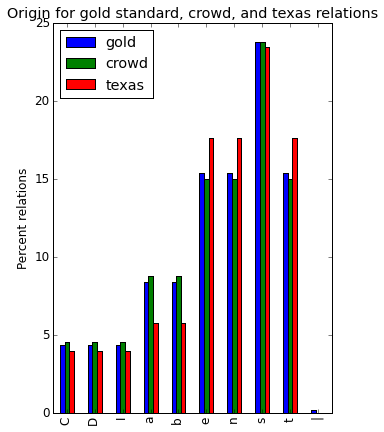

In [211]:
a = triple_origin(gold_triples, eval_gold, return_res = True)
b = triple_origin(crowd_trip, crowd_full, return_res = True)
c = triple_origin(ut_trip, ut_full, return_res = True)

rel_origins = pd.DataFrame([a, b, c], index = ["gold", "crowd", "texas"])

ax = rel_origins.T.plot(kind = "bar", figsize = (5, 7),
                    title = "Origin for gold standard, crowd, and texas relations")
ax.set_ylabel("Percent relations")
rel_origins

Seems like the crowd's answer response distribution is much closer to that of the gold's. The UTexas solution seems to prefer sentence-bound relations.

---

### Make one comprehensive dataframe for easier analysis

In [49]:
def new_check_exists(df, reference, ref_name):
    triple = ["pmid", "chemical_id", "disease_id"]
    for col in ["chemical", "disease"]:
        col_name = "{0}_in_{1}".format(col[:4], ref_name)
        
        df.loc[:, col_name] = df[triple].apply(
            lambda row: has_concept(reference[int(row["pmid"])], row["{}_id".format(col)]), axis = 1)
        
    return df

In [50]:
def single_triple_origin(pmid, chemical_id, disease_id, reference):
    triple = (pmid, chemical_id, disease_id)
    
    res = rel_origin(triple, reference[pmid])
    return "|".join(sorted(res))

In [51]:
def num_times_cooccur(pmid, chemical_id, disease_id, rel_origin, reference):
    """Given a relation triple and a reference Paper object,
    determines how many times the relation cooccurs (a sentence
    if CID or sentence, and 1 otherwise (abstract)).
    """
    if not rel_origin:
        # was not found using this solution
        return np.nan
    
    if rel_origin == "abs":
        return 1
    
    paper = reference[pmid]
    
    rel = Relation(pmid, chemical_id, disease_id, flat = False)
        
    ans = 0
    for sentence in paper.sentences:
        all_rels = sentence.poss_relations[rel_origin == "CID"]
        all_rels = [Relation(pmid, chem_set, dise_set) for chem_set, dise_set in all_rels]
        ans += int(rel in all_rels)
        
    return ans

In [52]:
# creating one comprehensive dataframe for easy result aggregation and querying

all_trips = gold_triples | crowd_trip | ut_trip
all_df = make_df(all_trips)

triple = ["pmid", "chemical_id", "disease_id"]

# which triple was found by which solution?
for name, reference in zip(["gold", "crowd", "texas"], [gold_triples, crowd_trip, ut_trip]):
    all_df.loc[:, "in_{}".format(name)] = all_df.loc[:, triple].apply(
        lambda row: (row["pmid"], row["chemical_id"], row["disease_id"]) in reference,
        axis = 1
    )
    
# were the concepts present in each dataset's concepts?
for name, reference in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):
    all_df = new_check_exists(all_df, reference, name)

# was the relation sentence bound or abstract level?
for name, reference in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):
    colname = "rel_orig_{}".format(name)
    
    all_df.loc[:, colname] = all_df.loc[:, triple].apply(
        lambda row: single_triple_origin(row["pmid"], row["chemical_id"], row["disease_id"], reference),
        axis = 1
    )
    
# how many times did the two concepts cooccur within the paper?    
for name, reference in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):    
    colname = "cooccur_{}".format(name)
    rel_orig = "rel_orig_{}".format(name)
    
    all_df.loc[:, colname] = all_df.loc[:, triple + [rel_orig]].apply(
        lambda row: num_times_cooccur(row["pmid"], row["chemical_id"], row["disease_id"],
                                     row[rel_orig], reference),
        axis = 1
    )

In [53]:
all_df.head()

,pmid,chemical_id,disease_id,in_gold,in_crowd,in_texas,chem_in_gold,dise_in_gold,chem_in_crowd,dise_in_crowd,chem_in_texas,dise_in_texas,rel_orig_gold,rel_orig_crowd,rel_orig_texas,cooccur_gold,cooccur_crowd,cooccur_texas
0,12051122,MESH:D014750,MESH:D007177,True,True,True,True,True,True,True,True,True,sent,sent,sent,6,5,5
1,24927617,MESH:D019821,MESH:D012206,True,False,True,True,True,True,True,True,True,sent,sent,sent,1,1,1
2,24333387,MESH:D007052,MESH:D020258,False,True,False,True,True,True,True,True,True,sent,sent,sent,1,1,1
3,8819482,MESH:D007545,MESH:D003251,False,False,True,True,True,True,True,True,True,sent,sent,sent,4,4,4
4,19108278,MESH:D004837,MESH:D001145,True,True,False,True,True,True,True,True,True,CID,CID,CID,1,1,1


---

### How many of the sentence and abstract relations did each method find? What was the precision?

In [215]:
def found_stats():
    recall = dict()
    precision = dict()
    for method in ["crowd", "texas"]:
        rec_temp = dict()
        pre_temp = dict()
        for rel_type in ["CID", "sent", "abs"]:
            sub = all_df.query("in_gold and rel_orig_gold == '{}'".format(rel_type))
            total = len(sub)
            found = len(sub.query("in_{}".format(method)))
            
            guesses = all_df.query("in_{0} and rel_orig_{0} == '{1}'".format(method, rel_type))
            guesses = len(guesses)
            
            rec_temp[rel_type] = found / total * 100
            pre_temp[rel_type] = found / guesses * 100
            
        recall[method] = rec_temp
        precision[method] = pre_temp
        
    print(recall)
        
    return (pd.DataFrame(recall), pd.DataFrame(precision))

In [216]:
recall, precision = found_stats()

{'crowd': {'sent': 54.0587219343696, 'CID': 87.11656441717791, 'abs': 36.392405063291136}, 'texas': {'sent': 63.903281519861835, 'CID': 83.43558282208589, 'abs': 35.44303797468354}}


In [214]:
recall

,crowd,texas
CID,87.116564,83.435583
abs,36.392405,35.443038
sent,54.058722,63.903282


,crowd,texas
CID,87.116564,83.435583
abs,36.392405,35.443038
sent,54.058722,63.903282


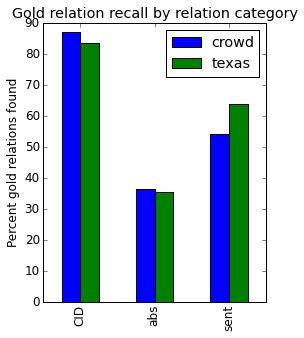

In [56]:
ax = recall.plot(kind = "bar", figsize = (4, 5),
        title = "Gold relation recall by relation category")

ax.set_ylabel("Percent gold relations found")

recall

,crowd,texas
CID,73.195876,82.926829
abs,30.503979,47.659574
sent,48.906250,51.388889


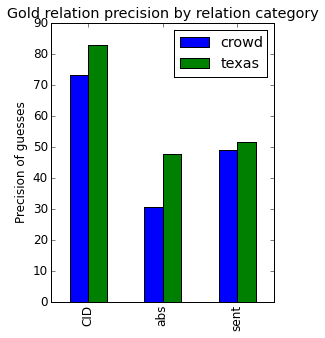

In [212]:
ax = precision.plot(kind = "bar", figsize = (4, 5),
        title = "Gold relation precision by relation category")

ax.set_ylabel("Precision of guesses")

precision

The two solutions found similar fractions of CID and abstract relations. The Texas solution found more sentence relations, but their predictions also contained more sentence-level relations overall. This is bad.. We are showing in different ways why the automated solution was better than our crowd..

### Of the relations which neither technique got, why did we not get them?

,any,chem,dise
crowd,63.888889,19.097222,49.652778
texas,56.944444,17.013889,42.708333


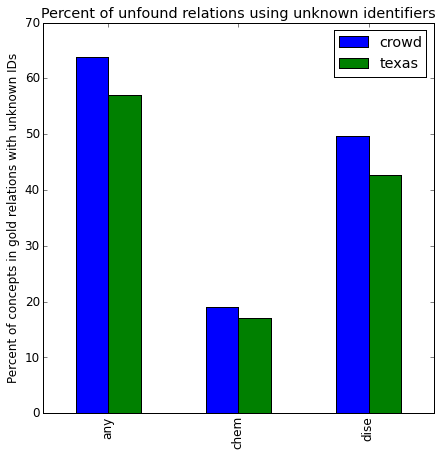

In [58]:
unfound = gold_triples - crowd_trip - ut_trip

crowd_miss = missing_stats(unfound, crowd_full)
ut_miss = missing_stats(unfound, ut_full)

missing = pd.DataFrame([crowd_miss, ut_miss], index = ["crowd", "texas"])

ax = missing.T.plot(kind = "bar", figsize = (7, 7),
             title = "Percent of unfound relations using unknown identifiers")

ax.set_ylabel("Percent of concepts in gold relations with unknown IDs")
missing

So a vast majority of the missed gold relations were unfound mainly because they used an ID which did not appear anywhere in the NER output for that paper.

For the relations which were indexed, what was the scope of the relation?

,abs,sent
crowd,55.769231,44.230769
texas,60.483871,39.516129


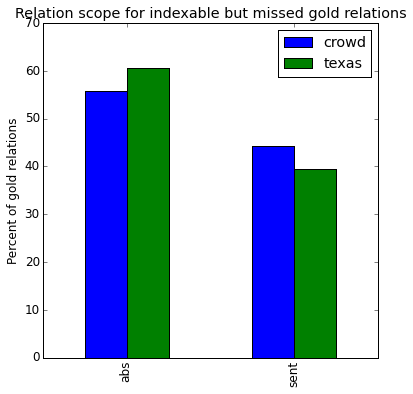

In [59]:
unfound = all_df.query("in_gold and ~in_crowd and ~in_texas")
crowd_miss = unfound.query("chem_in_crowd and dise_in_crowd")["rel_orig_gold"].value_counts(normalize = True) * 100
texas_miss = unfound.query("chem_in_texas and dise_in_texas")["rel_orig_gold"].value_counts(normalize = True) * 100

missed = pd.DataFrame([crowd_miss, texas_miss], index = ["crowd", "texas"])

ax = missed.T.plot(kind = "bar", figsize = (6, 6),
                title = "Relation scope for indexable but missed gold relations")

ax.set_ylabel("Percent of gold relations")
missed

For both solutions, at least half of the indexable, missed gold relations were abstract scoped, and therefore likely harder to determine correctly. Texas's solution seems to have a slight bias for the abstract scoped relations, but the different is probably not significant.

---

### For the relations which were false positives, what percentage were due to NER errors?

,any,chem,dise
crowd_only,34.435798,5.058366,30.350195
texas_only,24.800000,8.800000,16.533333
crowd_and_texas,9.090909,1.652893,7.438017


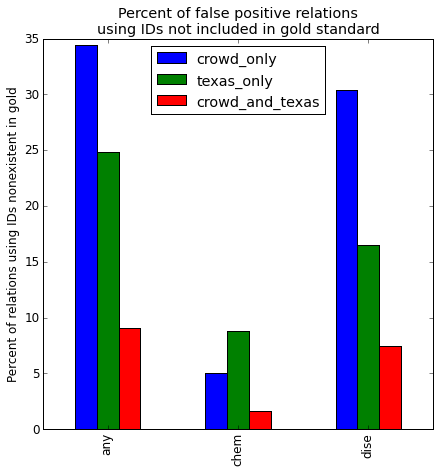

In [60]:
crowd_only = crowd_trip - gold_triples - ut_trip
texas_only = ut_trip - gold_triples - crowd_trip
crowd_ut = crowd_trip & ut_trip - gold_triples

cr_miss = missing_stats(crowd_only, eval_gold)
ut_miss = missing_stats(texas_only, eval_gold)
both_miss = missing_stats(crowd_ut, eval_gold)

missing = pd.DataFrame([cr_miss, ut_miss, both_miss], index = ["crowd_only", "texas_only", "crowd_and_texas"])

ax = missing.T.plot(kind = "bar", figsize = (7, 7),
                   title = "Percent of false positive relations\nusing IDs not included in gold standard")
ax.set_ylabel("Percent of relations using IDs nonexistent in gold")
missing

A significant number of the false positives for both solutions separately were a result of using MeSH IDs which did not occur in the gold standard. However, the false positives identified by both solutions have a significantly lower rate of NER error, suggesting that these were likely to be real relations which the gold does not include for some reason.

---

### For the gold relations which one solution got but the other missed, why did each solution miss the relations and what kind of relations are they?

,any,chem,dise
crowd_rels_missed_by_texas,20.645161,3.225806,17.419355
texas_rels_missed_by_crowd,40.099010,14.851485,28.217822


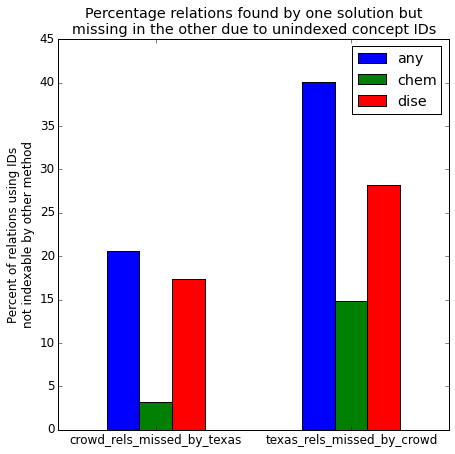

In [61]:
crowd_gold = all_df.query("in_gold and in_crowd and ~in_texas")
texas_gold = all_df.query("in_gold and in_texas and ~in_crowd")

crowd_gold = get_triples(crowd_gold)
texas_gold = get_triples(texas_gold)

# unindexable by texas, and by crowd
miss_by_ut = missing_stats(crowd_gold, ut_full)
miss_by_cr = missing_stats(texas_gold, crowd_full)

missing = pd.DataFrame([miss_by_ut, miss_by_cr],
                       index = ["crowd_rels_missed_by_texas", "texas_rels_missed_by_crowd"])
ax = missing.plot(kind = "bar", figsize = (7, 7),
                 title = "Percentage relations found by one solution but\n"
                 "missing in the other due to unindexed concept IDs")
ax.set_ylabel("Percent of relations using IDs\nnot indexable by other method")
ax.set_xticklabels(missing.index, rotation = 0)
missing

Based on the graph above, we see that the relations which our crowd got but Texas didn't only contained a small subset where the relations contained IDs which were not indexed by Texas. In contrast, a lot of the relations (40%) that Texas got but the crowd didn't were because the IDs were never found, not because the crowd is bad at relation extraction.

---